In [1]:
import shutil
import sys

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder


import torch
import torch.nn as nn
from transformers import BertTokenizer
from transformers import pipeline


import nltk
from nltk.corpus import wordnet
from deep_translator import GoogleTranslator
from googletrans import Translator


from tqdm import tqdm
import tqdm.notebook as tq

import random
import time

from collections import defaultdict, Counter


#nltk.download('wordnet')
#nltk.download('omw-1.4')

translator = Translator()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
# Hyperparameters
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

MAX_LEN = 30
#MAX_LEN = min(30, max(df_train['Utterances'].str.split().apply(len).max(), 50))
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 0.001 #1e-05
THRESHOLD = 0.2 # threshold for the sigmoid

In [3]:
df_data = pd.read_csv('MEISD/MEISD_text.csv')

In [4]:
df_data.head()

,TV Series,Utterances,dialog_ids,uttr_ids,seasons,episodes,start_times,end_times,sentiment,emotion,intensity,emotion2,intensity2,emotion3,intensity3
0,GA,look around you,1,0,1,1,00:02:27:589,00:02:28:567,neutral,neutral,NaN,NaN,NaN,NaN,NaN
1,GA,say hello to your competition,1,1,1,1,00:02:28:910,00:02:30:513,neutral,neutral,NaN,NaN,NaN,NaN,NaN
2,GA,eight of you will switch to an easier specialty,1,2,1,1,00:02:31:387,00:02:34:060,neutral,neutral,NaN,NaN,NaN,NaN,NaN
3,GA,five of you will crack under the pressure,1,3,1,1,00:02:34:134,00:02:36:002,neutral,neutral,NaN,NaN,NaN,NaN,NaN
4,GA,two of you will be asked to leave,1,4,1,1,00:02:36:059,00:02:37:723,neutral,neutral,NaN,NaN,NaN,NaN,NaN


In [5]:
def check_data_integrity(df):
    print("=== Weryfikacja integralności danych ===")

    print("\n>>> Sprawdzanie brakujących wartości:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])

    print("\n>>> Typy danych:")
    print(df.dtypes)

    print("\n>>> Liczba duplikatów:")
    duplicates = df.duplicated().sum()
    print(f"Liczba zduplikowanych wierszy: {duplicates}")

    print("\n>>> Zakres wartości w kolumnach liczbowych:")
    for col in df.select_dtypes(include=[np.number]).columns:
        print(f"{col}: min = {df[col].min()}, max = {df[col].max()}")

    print("\n>>> Unikalne wartości w kolumnach kluczowych:")
    for col in ['emotion', 'emotion2', 'emotion3']:
        if col in df.columns:
            print(f"{col}: {df[col].unique()}")

    print("\nWeryfikacja zakończona.\n")


# Funkcja do weryfikacji kompletności danych
def verify_data_integrity(data):
    issues = []

    if 'combined_emotions' not in data.columns:
        print("Column 'combined_emotions' is missing!")
        return

    for idx, entry in data.iterrows():
        combined_emotions = entry['combined_emotions']

        if not combined_emotions:  
            issues.append(f"Entry {idx} has an empty 'combined_emotions' list.")
        elif not isinstance(combined_emotions, list):  
            issues.append(f"Entry {idx} has 'combined_emotions' which is not a list.")

    if issues:
        print("Data integrity check failed:")
        for issue in issues:
            print(issue)
    else:
        print("All entries in 'combined_emotions' are valid!")

check_data_integrity(df_data)

=== Weryfikacja integralności danych ===

>>> Sprawdzanie brakujących wartości:
intensity      3568
emotion2      11128
intensity2    11129
emotion3      19950
intensity3    19950
dtype: int64

>>> Typy danych:
TV Series       object
Utterances      object
dialog_ids       int64
uttr_ids         int64
seasons          int64
episodes         int64
start_times     object
end_times       object
sentiment       object
emotion         object
intensity       object
emotion2        object
intensity2      object
emotion3        object
intensity3     float64
dtype: object

>>> Liczba duplikatów:
Liczba zduplikowanych wierszy: 0

>>> Zakres wartości w kolumnach liczbowych:
dialog_ids: min = 1, max = 1125
uttr_ids: min = 0, max = 40
seasons: min = 1, max = 10
episodes: min = 1, max = 26
intensity3: min = 1.0, max = 3.0

>>> Unikalne wartości w kolumnach kluczowych:
emotion: ['neutral' 'acceptance' 'disgust' 'surprise' 'joy' 'sadness' 'anger'
 'like' 'fear' 'acceptance ' 'faer' 'Fear ' 'fear ' 'Fe

In [6]:
unique_emotions = set(df_data['emotion'].unique()) | set(df_data['emotion2'].unique()) | set(df_data['emotion3'].unique())
print(unique_emotions)

{'Disgust', 'sadness', 'disgust', 'Fear', ' anger', 'Fera', 'Surprise ', nan, 'sadness ', ' disgust', 'Joy', 'joy', 'faer', ' surprise', 'like', 'anger', 'fear', 'fear ', 'surprise', 'sur', 'asadness', '  disgust', 'anger1', 'neutral ', 'Neutral', 'digust', 'sadnes', 'acceptance', 'Sadness', ' sadness', 'neutral', 'Anger', 'acceptance ', 'Fear ', 'ANGER', 'Surprise', 'Neutral ', 'an', 'l', 'Sadness '}


In [7]:
emotion_map = {
    'neutral': 0, 'Neutral': 0, 'Neutral ': 0, 'neutral ': 0,
    'acceptance': 1, 'acceptance ': 1,
    'disgust': 2, 'Disgust': 2, ' disgust': 2, '  disgust': 2, 'digust': 2,
    'surprise': 3, 'Surprise': 3, ' surprise': 3, 'Surprise ': 3, 'sur': 3,
    'joy': 4, 'Joy': 4, 'like': 4,
    'sadness': 5, 'Sadness': 5, ' sadness': 5, 'Sadness ': 5, 'sadness ': 5, 'sadnes': 5, 'asadness': 5,
    'anger': 6, 'Anger': 6, ' anger': 6, 'ANGER': 6, 'anger1': 6, 'an': 6,
    'fear': 8, 'Fear': 8, 'fear ': 8, 'Fear ': 8, 'faer': 8, 'Fera': 8,
    'l': None, np.nan: None
}

data_emotion = pd.DataFrame()
data_emotion['Utterances'] = df_data['Utterances']

data_emotion['target1'] = df_data['emotion'].map(emotion_map)
data_emotion['target2'] = df_data['emotion2'].map(emotion_map)
data_emotion['target3'] = df_data['emotion3'].map(emotion_map)


def fill_nans(row):
    if row.isna().sum() == 2 and row.count() == 1:
        row = row.fillna(row.dropna().iloc[0])

    elif row.isna().sum() == 1 and row.count() == 2:
        row = row.fillna(row.dropna().iloc[0])

    return row


data_emotion[['target1', 'target2', 'target3']] = data_emotion[['target1', 'target2', 'target3']].apply(fill_nans, axis=1)

data_emotion['target1'] = data_emotion['target1'].astype(int)
data_emotion['target2'] = data_emotion['target2'].astype(int)
data_emotion['target3'] = data_emotion['target3'].astype(int)

In [8]:
data_emotion.head(5)

,Utterances,target1,target2,target3
0,look around you,0,0,0
1,say hello to your competition,0,0,0
2,eight of you will switch to an easier specialty,0,0,0
3,five of you will crack under the pressure,0,0,0
4,two of you will be asked to leave,0,0,0


In [9]:
data_emotion['combined_emotions'] = data_emotion[['target1', 'target2', 'target3']].apply(lambda x: x.dropna().unique().astype(int).tolist(), axis=1)

In [10]:
verify_data_integrity(data_emotion)

All entries in 'combined_emotions' are valid!


In [11]:
# One-hot encoding
mlb_emotion = MultiLabelBinarizer()
emotion_binarized = mlb_emotion.fit_transform(data_emotion['combined_emotions'])
emotion_df = pd.DataFrame(emotion_binarized, columns=[f'emotion_{i+1}' for i in range(emotion_binarized.shape[1])])

In [12]:
check_data_integrity(emotion_df)

=== Weryfikacja integralności danych ===

>>> Sprawdzanie brakujących wartości:
Series([], dtype: int64)

>>> Typy danych:
emotion_1    int32
emotion_2    int32
emotion_3    int32
emotion_4    int32
emotion_5    int32
emotion_6    int32
emotion_7    int32
emotion_8    int32
dtype: object

>>> Liczba duplikatów:
Liczba zduplikowanych wierszy: 19970

>>> Zakres wartości w kolumnach liczbowych:
emotion_1: min = 0, max = 1
emotion_2: min = 0, max = 1
emotion_3: min = 0, max = 1
emotion_4: min = 0, max = 1
emotion_5: min = 0, max = 1
emotion_6: min = 0, max = 1
emotion_7: min = 0, max = 1
emotion_8: min = 0, max = 1

>>> Unikalne wartości w kolumnach kluczowych:

Weryfikacja zakończona.


In [13]:
multi_label_binarizer_MEISD = pd.concat([data_emotion['Utterances'], emotion_df], axis=1)
multi_label_binarizer_MEISD

,Utterances,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8
0,look around you,1,0,0,0,0,0,0,0
1,say hello to your competition,1,0,0,0,0,0,0,0
2,eight of you will switch to an easier specialty,1,0,0,0,0,0,0,0
3,five of you will crack under the pressure,1,0,0,0,0,0,0,0
4,two of you will be asked to leave,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
20012,"oh, that's right, you're a woman and you need ...",0,0,1,0,0,0,1,0
20013,i'll try again,0,0,1,0,0,0,1,0
20014,"please, pam, reconsider and have a bagel",0,1,1,0,0,0,0,0
20015,i have an early lunch,0,0,1,0,0,0,1,0


In [14]:
# Data Augmentation

# 1. Synonym Replacement
def synonym_replacement(text):
    words = text.split()
    new_words = words[:]
    num_replacements = max(1, len(words) // 5)  # Replace about 20% of words
    random_words = random.sample(words, num_replacements)

    for word in random_words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            #synonym = synonyms[0].lemmas()[0].name()  # Take first synonym
            synonym = random.choice(synonyms).lemmas()[0].name()
            if synonym != word:  # Avoid replacement if the synonym is identical
                new_words = [synonym if w == word else w for w in new_words]
    return ' '.join(new_words)


# 2. Random Insertion
def random_insertion(text, n=1):
    words = text.split()
    for _ in range(n):
        new_word = random.choice(words)
        insert_pos = random.randint(0, len(words))
        words.insert(insert_pos, new_word)
    return ' '.join(words)


# 3. Random Deletion
def random_deletion(text, p=0.3):
    words = text.split()
    if len(words) == 1:
        return text  # Avoid deleting single-word text
    new_words = [word for word in words if random.uniform(0, 1) > p]
    if not new_words:
        return random.choice(words)  # Return one word if all words are deleted
    return ' '.join(new_words)

# 4. Back Translation
def back_translation(text, src_lang='en', mid_lang='fr', max_retries=3):
    attempt = 0
    while attempt < max_retries:
        try:
            translated = GoogleTranslator(source=src_lang, target=mid_lang).translate(text)
            back_translated = GoogleTranslator(source=mid_lang, target=src_lang).translate(translated)
            return back_translated
        except Exception as e:
            print(f"Back translation error on attempt {attempt + 1}: {e}")
            attempt += 1
            time.sleep(1)
    raise ValueError("Back translation failed")

In [15]:
def augment_text(text, num_augments=2):
    augmented_texts = []
    for _ in range(num_augments):
        augmentation_choice = random.choice(['synonym', 'insertion', 'deletion', 'back_translation'])
        if augmentation_choice == 'synonym':
            augmented_texts.append(synonym_replacement(text))
        elif augmentation_choice == 'insertion':
            augmented_texts.append(random_insertion(text))
        elif augmentation_choice == 'deletion':
            augmented_texts.append(random_deletion(text))
        elif augmentation_choice == 'back_translation':
            augmented_texts.append(back_translation(text))
    return augmented_texts

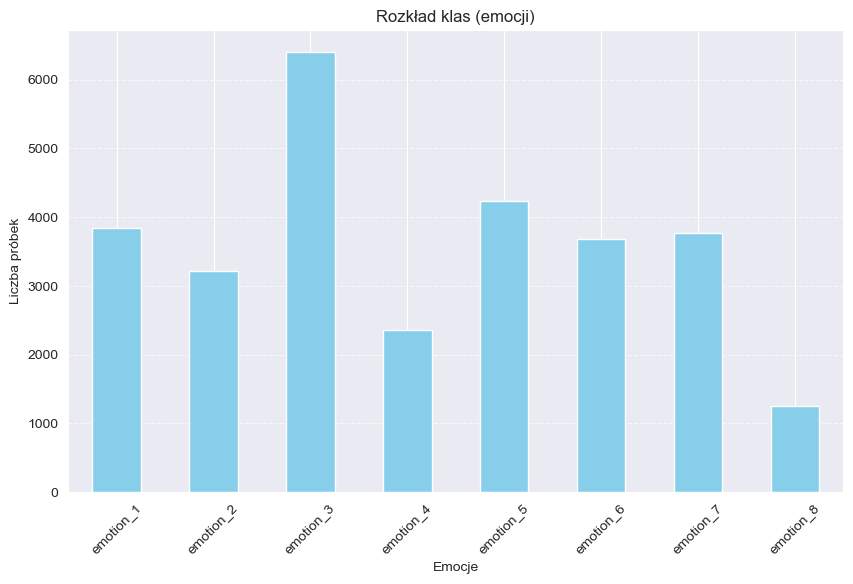

In [16]:
label_sums = multi_label_binarizer_MEISD.iloc[:, 1:].sum()

plt.figure(figsize=(10, 6))
label_sums.plot(kind='bar', color='skyblue')
plt.title('Rozkład klas (emocji)')
plt.xlabel('Emocje')
plt.ylabel('Liczba próbek')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [17]:
# split into train and test
df_train, df_test = train_test_split(multi_label_binarizer_MEISD, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_train, random_state=88, test_size=0.50, shuffle=True)

In [18]:
df_train.head()

,Utterances,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8
13858,had you asked a couple of weeks ago,1,0,0,0,0,0,0,0
14789,Yeah! Richard!,0,0,0,0,0,0,1,0
17589,young benjamin here knows what's coming,0,0,1,0,0,0,1,0
8549,i don't see why they had to keep my credit car...,0,0,0,0,0,1,1,0
18378,between us,0,0,0,0,0,1,0,0


In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14011 entries, 13858 to 15063
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Utterances  14011 non-null  object
 1   emotion_1   14011 non-null  int32 
 2   emotion_2   14011 non-null  int32 
 3   emotion_3   14011 non-null  int32 
 4   emotion_4   14011 non-null  int32 
 5   emotion_5   14011 non-null  int32 
 6   emotion_6   14011 non-null  int32 
 7   emotion_7   14011 non-null  int32 
 8   emotion_8   14011 non-null  int32 
dtypes: int32(8), object(1)
memory usage: 656.8+ KB


In [20]:
class_counts = df_train[['emotion_1', 'emotion_2', 'emotion_3', 'emotion_4',
                         'emotion_5', 'emotion_6', 'emotion_7', 'emotion_8']].sum(axis=0)

max_count = class_counts.max()
class_counts

emotion_1    2701
emotion_2    2236
emotion_3    4509
emotion_4    1674
emotion_5    2941
emotion_6    2563
emotion_7    2631
emotion_8     842
dtype: int64

In [21]:
def check_balance(class_counts):
    """
    Analizuje balans w danych na podstawie liczby próbek w każdej klasie.

    Args:
        class_counts (list or dict): Liczność próbek w klasach. Może być listą liczb
                                     lub słownikiem {nazwa_klasy: liczba_próbek}.
    Returns:
        dict: Słownik z obliczonymi miarami balansu:
              - Rozpiętość (range)
              - Odchylenie standardowe (std)
              - Średnia liczba próbek (mean)
              - Największa klasa (max_class)
              - Najmniejsza klasa (min_class)
              - Interpretacja (interpretation)
    """
    if isinstance(class_counts, dict):
        class_counts = list(class_counts.values())

    max_count = max(class_counts)
    min_count = min(class_counts)
    mean_count = np.mean(class_counts)
    std_count = np.std(class_counts)
    range_count = max_count - min_count

    # Interpretacja balansu
    if std_count < 0.1 * mean_count:
        interpretation = "Dane są bardzo dobrze zbalansowane."
    elif std_count < 0.3 * mean_count:
        interpretation = "Dane są umiarkowanie zbalansowane."
    else:
        interpretation = "Dane są niezbalansowane."

    return {
        "range": range_count,
        "std": std_count,
        "mean": mean_count,
        "max_class": max_count,
        "min_class": min_count,
        "interpretation": interpretation
    }

In [22]:
check_balance(class_counts)

{'range': 3667,
 'std': 986.9050660397888,
 'mean': 2512.125,
 'max_class': 4509,
 'min_class': 842,
 'interpretation': 'Dane są niezbalansowane.'}

In [23]:
from tqdm import tqdm

def augment_multilabel_data(df, label_columns, augment_text, num_augments=2):
    """
    Augments multilabel data to balance class distributions, ignoring samples with the most frequent class.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with 'Utterances' column and label columns.
    - label_columns (list): List of column names corresponding to binary label columns.
    - augment_text (callable): Function to augment text. Should take a string and return a list of augmented strings.
    - num_augments (int): Number of augmented samples to generate per original sample.

    Returns:
    - pd.DataFrame: Augmented DataFrame with balanced class distributions.
    """
    # Calculate class counts
    class_counts = {label: df[label].sum() for label in label_columns}
    max_count = max(class_counts.values())
    most_frequent_class = max(class_counts, key=class_counts.get)

    print(f"Class counts: {class_counts}")
    print(f"Maximum class count: {max_count}")
    print(f"Most frequent class: {most_frequent_class} (ignoring samples with this label)")

    # Initialize storage for augmented data
    augmented_data = {'Utterances': [], **{label: [] for label in label_columns}}

    for label in label_columns:
        if label == most_frequent_class:
            print(f"Skipping augmentation for the most frequent class '{label}'.")
            continue  # Skip augmenting the most frequent class

        # Select rows where the current label is 1
        class_subset = df[df[label] == 1]
        augmented_data['Utterances'].extend(class_subset['Utterances'])
        for lbl in label_columns:
            augmented_data[lbl].extend(class_subset[lbl])

        # Calculate how many samples to augment
        num_to_augment = max_count - len(class_subset)

        if num_to_augment > 0:
            print(f"Augmenting class '{label}' with {num_to_augment} samples.")
            for _, row in tqdm(class_subset.iterrows(), total=len(class_subset), desc=f"Augmenting {label}"):
                if num_to_augment <= 0:
                    break

                # Perform text augmentation
                new_texts = augment_text(row['Utterances'], num_augments=num_augments)
                for new_text in new_texts:
                    if num_to_augment <= 0:
                        break
                    augmented_data['Utterances'].append(new_text)

                    # Add the multilabels for the augmented data
                    for lbl in label_columns:
                        augmented_data[lbl].append(row[lbl])

                    num_to_augment -= 1

    # Create a new DataFrame with augmented data
    augmented_df = pd.DataFrame(augmented_data)
    return augmented_df


In [24]:
augmented_df = augment_multilabel_data(
    df=df_train,
    label_columns=[f"emotion_{i}" for i in range(1, 9)],
    augment_text=augment_text,
    num_augments=2
)

print(augmented_df)

Class counts: {'emotion_1': 2701, 'emotion_2': 2236, 'emotion_3': 4509, 'emotion_4': 1674, 'emotion_5': 2941, 'emotion_6': 2563, 'emotion_7': 2631, 'emotion_8': 842}
Maximum class count: 4509
Most frequent class: emotion_3 (ignoring samples with this label)
Augmenting class 'emotion_1' with 1808 samples.


Augmenting emotion_1:  33%|███▎      | 904/2701 [10:01<19:55,  1.50it/s]  


Augmenting class 'emotion_2' with 2273 samples.


Augmenting emotion_2:  51%|█████     | 1137/2236 [11:16<10:54,  1.68it/s]


Skipping augmentation for the most frequent class 'emotion_3'.
Augmenting class 'emotion_4' with 2835 samples.


Augmenting emotion_4:  85%|████████▍ | 1418/1674 [16:41<03:00,  1.42it/s]


Augmenting class 'emotion_5' with 1568 samples.


Augmenting emotion_5:  27%|██▋       | 784/2941 [09:19<25:40,  1.40it/s]  


Augmenting class 'emotion_6' with 1946 samples.


Augmenting emotion_6:  38%|███▊      | 973/2563 [11:21<18:33,  1.43it/s]


Augmenting class 'emotion_7' with 1878 samples.


Augmenting emotion_7:  36%|███▌      | 939/2631 [09:33<17:12,  1.64it/s]


Augmenting class 'emotion_8' with 3667 samples.


Augmenting emotion_8: 100%|██████████| 842/842 [08:17<00:00,  1.69it/s]

                                              Utterances  emotion_1  \
0                    had you asked a couple of weeks ago          1   
1        Jaime's away on a sensitive diplomatic mission.          1   
2                            Look into the fire my king.          1   
3                                                domingo          1   
4                                                 You...          1   
...                                                  ...        ...   
29575  chase: so you're say we put pressure on his aorta          0   
29576                               Michael, don't panic          0   
29577                               michael, don't panic          0   
29578  They're carrying his flaming heart banners. ba...          0   
29579                 They're carrying his flaming heart          0   

       emotion_2  emotion_3  emotion_4  emotion_5  emotion_6  emotion_7  \
0              0          0          0          0          0          0 

In [25]:
class_counts = augmented_df[['emotion_1', 'emotion_2', 'emotion_3', 'emotion_4',
                         'emotion_5', 'emotion_6', 'emotion_7', 'emotion_8']].sum(axis=0)
max_count = class_counts.max()
class_counts

emotion_1    4512
emotion_2    6574
emotion_3    6856
emotion_4    5704
emotion_5    7404
emotion_6    6356
emotion_7    5470
emotion_8    3434
dtype: int64

In [26]:
check_balance(class_counts)

{'range': 3970,
 'std': 1223.2215406458472,
 'mean': 5788.75,
 'max_class': 7404,
 'min_class': 3434,
 'interpretation': 'Dane są umiarkowanie zbalansowane.'}

In [27]:
augmented_df.to_csv('balanced_augmented_emotion_data.csv', index=False)

In [ ]:
# augmented_data = {'Utterances': [], 'emotion_1': [], 'emotion_2': [], 'emotion_3': [],
#                   'emotion_4': [], 'emotion_5': [], 'emotion_6': [], 'emotion_7': [], 'emotion_8': []}
# 
# df_train_no_emotion3 = df_train[df_train['emotion_3'] == 0]
# 
# for idx, row in tqdm(df_train_no_emotion3.iterrows(), total=len(df_train_no_emotion3), desc="Augmenting data"):
#     emotions = row[['emotion_1', 'emotion_2', 'emotion_3', 'emotion_4',
#                     'emotion_5', 'emotion_6', 'emotion_7', 'emotion_8']].values
#     emotions = emotions.astype(int) 
#     present_emotions = np.where(emotions == 1)[0]
#     num_to_augment = max_count - len(present_emotions)
#     num_to_augment = min(num_to_augment, 500)
# 
#     if num_to_augment > 0:
#         new_texts = augment_text(row['Utterances'], num_augments=num_to_augment) 
#         for new_text in new_texts:
#             augmented_data['Utterances'].append(new_text)
#             for i in range(8):
#                 augmented_data[f'emotion_{i+1}'].append(emotions[i]) 
# 
# augmented_df = pd.DataFrame(augmented_data)
# 
# df_train_augmented = pd.concat([df_train, augmented_df], ignore_index=True)
# 
# augmented_class_counts = df_train_augmented[['emotion_1', 'emotion_2', 'emotion_3', 'emotion_4',
#                                              'emotion_5', 'emotion_6', 'emotion_7', 'emotion_8']].sum(axis=0)
# 
# print(augmented_class_counts)

In [ ]:
# def augment_data_sample(df, num_samples=20, max_count=5, num_augments=3, augment_text_fn=None):
#     """
#     Augmentacja danych na małej próbce.
# 
#     :param df: DataFrame z danymi wejściowymi
#     :param num_samples: Liczba próbek do przetestowania
#     :param max_count: Maksymalna liczba emocji, które powinny być w danych
#     :param num_augments: Liczba augmentacji, które powinny zostać wygenerowane
#     :param augment_text_fn: Funkcja do generowania nowych tekstów
#     :return: DataFrame z augmentowanymi danymi
#     """
#     augmented_data = {'Utterances': [], 'emotion_1': [], 'emotion_2': [], 'emotion_3': [],
#                       'emotion_4': [], 'emotion_5': [], 'emotion_6': [], 'emotion_7': [], 'emotion_8': []}
# 
#     sample_data = df.head(num_samples)
# 
#     for idx, row in tqdm(sample_data.iterrows(), total=len(sample_data), desc="Testing Augmentation"):
#         emotions = row[['emotion_1', 'emotion_2', 'emotion_3', 'emotion_4',
#                         'emotion_5', 'emotion_6', 'emotion_7', 'emotion_8']].values
#         emotions = emotions.astype(int)
#         present_emotions = np.where(emotions == 1)[0]
#         num_to_augment = max_count - len(present_emotions)
# 
#         if num_to_augment > 0:
#             new_texts = augment_text_fn(row['Utterances'], num_augments=num_to_augment)
#             for new_text in new_texts:
#                 augmented_data['Utterances'].append(new_text)
#                 for i in range(8):
#                     augmented_data[f'emotion_{i+1}'].append(emotions[i])
# 
#     augmented_df = pd.DataFrame(augmented_data)
# 
#     return augmented_df


In [ ]:
# sample_data = df_train.head(100)
# 
# augmented_data = {'Utterances': [], 'emotion_1': [], 'emotion_2': [], 'emotion_3': [],
#                   'emotion_4': [], 'emotion_5': [], 'emotion_6': [], 'emotion_7': [], 'emotion_8': []}
# 
# for idx, row in tqdm(df_train.iterrows(), total=len(df_train), desc="Augmenting data"):
#     emotions = row[['emotion_1', 'emotion_2', 'emotion_3', 'emotion_4',
#                     'emotion_5', 'emotion_6', 'emotion_7', 'emotion_8']].values
#     emotions = emotions.astype(int) 
#     present_emotions = np.where(emotions == 1)[0]
#     num_to_augment = max_count - len(present_emotions)
# 
#     if num_to_augment > 0:
#         new_texts = augment_text(row['Utterances'], num_augments=num_to_augment)
#         for new_text in new_texts:
#             augmented_data['Utterances'].append(new_text)
#             for i in range(8):
#                 augmented_data[f'emotion_{i+1}'].append(emotions[i])
# 
# augmented_df = pd.DataFrame(augmented_data)
# 
# print(augmented_df.head())

In [ ]:
df_train_augmented = pd.concat([df_train, augmented_df], ignore_index=True)

print(df_train_augmented[['emotion_1', 'emotion_2', 'emotion_3', 'emotion_4',
                          'emotion_5', 'emotion_6', 'emotion_7', 'emotion_8']].sum(axis=0))

In [ ]:
print(f"Original train size: {df_train.shape}")
#print(f"Augmented train size: {augmented_df.shape}")

# df_train = augmented_df

print(f"Validation size: {df_valid.shape}, Test size: {df_test.shape}")

In [ ]:
# label_frequencies = df_train['label'].value_counts()
# label_frequencies_percent = df_train['label'].value_counts(normalize=True) * 100
# print(label_frequencies_percent)
# print(label_frequencies)


In [ ]:
# class_distribution = df_train['label'].value_counts(normalize=True)
# print(class_distribution)

In [ ]:
# import matplotlib.pyplot as plt
# 
# # Wykres rozkładu klas
# class_distribution.plot(kind='bar')
# plt.title('Class Distribution')
# plt.xlabel('Sentiment Class')
# plt.ylabel('Number of Samples')
# plt.xticks(rotation=0)
# plt.show()

In [ ]:
print(f"Original train size: {multi_label_binarizer_MEISD.shape}")
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length",
                                  return_attention_mask = True,
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html) 
encodings

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['Utterances'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

In [ ]:
target_list = list(multi_label_binarizer_MEISD.columns)[1:]
target_list

In [ ]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [ ]:
next(iter(train_dataset))

In [ ]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=TRAIN_BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=0
                                                )

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
                                              batch_size=VALID_BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=0
                                              )

test_data_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=0
                                               )

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 8)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)  

In [ ]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = LEARNING_RATE)  

In [ ]:
def train_model(training_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    #all_preds = []
    #all_labels = []

    model.train()

    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), leave=True, colour='steelblue')

    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array
        
        
        #all_preds.extend(outputs.flatten())
        #all_labels.extend(targets.flatten())

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    #train_f1 = f1_score(all_labels, all_preds, average='weighted')

    return model, float(correct_predictions) / num_samples, np.mean(losses)#, train_f1


In [ ]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    #all_preds = []
    #all_labels = []

    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()

            correct_predictions += np.sum(outputs == targets)
            num_samples += targets.size

            #all_preds.extend(outputs.flatten())
            #all_labels.extend(targets.flatten())

    avg_loss = np.mean(losses)
    #val_f1 = f1_score(all_labels, all_preds, average='weighted')

    return float(correct_predictions) / num_samples, np.mean(losses), avg_loss#, val_f1


In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    print(f'Train loss {train_loss:.4f} | Train accuracy {train_acc:.4f}')

    val_acc, val_loss, avg_loss = eval_model(val_data_loader, model, optimizer)
    print(f'Val loss {val_loss:.4f} | Val accuracy {val_acc:.4f}')


    #print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)

    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), "emotion_best_model_state.bin")
        best_f1 = val_acc
        print("Saved new best model.")
     

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()


## Evaluation of the model

In [ ]:
# Model Evaluation
# Loading pretrained model (best model)
model = BERTClass()
model.load_state_dict(torch.load(os.path.join("emotion_best_model_state.bin")))
model = model.to(device)

In [ ]:
# Evaluate the model using the test data
test_acc, test_loss, avg_loss = eval_model(test_data_loader, model, optimizer)

In [ ]:
# The accuracy looks OK, similar to the validation accuracy
# The model generalizes well !
test_acc

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()

    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
        for data in data_loader:
            title = data["title"]
            ids = data["input_ids"].to(device, dtype = torch.long)
            mask = data["attention_mask"].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data["targets"].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).detach().cpu()
            # thresholding at 0.5
            preds = outputs.round()
            targets = targets.detach().cpu()

            titles.extend(title)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            target_values.extend(targets)

    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)

    return titles, predictions, prediction_probs, target_values


In [ ]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [ ]:
# sanity check
predictions.numpy()

In [ ]:
print(f"titles:{len(titles)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

In [ ]:
# Generate Classification Metrics
#
# note that the total support is greater than the number of samples because some samples have multiple labels

print(classification_report(target_values, predictions, target_names=target_list))